In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from collections import Counter
import keras 


C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1. Word vectorizer

In [2]:
corpus = pd.read_table('data.txt')[:1000]
corpus = [i.split() for i in corpus['10768'].values]
bag = [[0 for _ in range(len(i))] for i in corpus]
word_dict = {}
i = 0
for doc_num in range(len(corpus)):
    for word_index in range(len(corpus[doc_num])):
        word = corpus[doc_num][word_index]
        if word in word_dict:
            bag[doc_num][word_index] = word_dict[word]
        else:            
            word_dict[word] = i
            bag[doc_num][word_index] = word_dict[word]
            i+=1
       

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [2]:
data = np.load('lda.npz')
data_train = data['train']
data_test = data['test']
data_train[:,0] = data_train[:,0]-1
data_test[:,0] = data_test[:,0]-1
def preprocess(data_train):
    text = [[] for _ in range(max(data_train[:,0])+1)]
    for doc in data_train:
        doc_index = doc[0]
        word_index = doc[1]
        num = doc[2]
        while num>0:
            text[doc_index].append(word_index)
            num-=1
    return text
bag = preprocess(data_train)

In [148]:
res = []
for vec in data_train:
    if vec[-1] ==1:
        res.append(vec)
    else:
        new_vec = vec.copy()
        new_vec[-1]=1
        for _ in range(vec[-1]):
            res.append(new_vec)
            

## 1.Initialization

*  Cluster number  $k$
* hyperparameter for two dirichlet conjugate $\alpha,\beta$
* The number of unique word **top_words_num**
* The number of document $n$
* nw 词在各topic的数量
* nwsum 每个topic词的总数
* nd 每个doc中topic的总数
* ndsum 每个doc中词的总数


In [7]:
k = 10
alpha = 1
beta = 1
top_words_num = max(data_train[:,1])+1
n = len(bag)

nw = np.zeros((top_words_num,k))
nwsum = np.zeros(k)
nd = np.zeros((n,k))

ndsum = np.zeros(n)

z = [[[0] for _ in range(len(l))] for l in bag] #topic for evary word in doc

for i in range(n):
    ndsum[i] = len(bag[i])
    for j in range(len(bag[i])):
        topic = np.random.randint(k)
        z[i][j] = topic
        nw[bag[i][j]][topic]+=1 
        nd[i][topic]+=1
        nwsum[topic]+=1
p = []

In [149]:
#超参数
k = 10
alpha = 1
beta = 1
top_words_num = max(data_train[:,1])+1
n = len(bag)

#变成word_num都是1
res = []
for vec in data_train:
    if vec[-1] ==1:
        res.append(vec)
    else:
        new_vec = vec.copy()
        new_vec[-1]=1
        for _ in range(vec[-1]):
            res.append(new_vec)

#初始化
doc_word_sum = np.zeros(n)
topic_word_sum = np.zeros(k)
doc_topic_count = np.zeros((n,k))
word_topic_count = np.zeros((top_words_num,k))
topic_att = []
for doc_idx,word_idx,word_num in res:
    topic = np.random.randint(0,k,1)[0] #随机初始化主题
    topic_att.append(topic)
    
    doc_word_sum[doc_idx]+=word_num #文档数量加上单词数量
    topic_word_sum[topic]+=word_num 
    
    doc_topic_count[doc_idx,topic]+=word_num
    word_topic_count[word_idx,topic]+=word_num
    
    

In [151]:
#更新z
loss_l = []
for it in range(1,20):
    start = time.time()
    nt = []
    print('第{}轮训练开始'.format(it))
    for ((doc_idx,word_idx,word_num),topic) in zip(res,topic_att):
            

        doc_topic_count[doc_idx,topic]-=1 #词在各topic的数量
        word_topic_count[word_idx,topic]-=1 #每个doc中topic的总数
        doc_word_sum[doc_idx]-=1 #nwsum 每个topic词的总数
        topic_word_sum[topic]-=1 #每个doc中词的总数

        topic_doc =  (doc_topic_count[doc_idx]+alpha)/(doc_word_sum[doc_idx] + k*alpha) #
        word_topic = (word_topic_count[word_idx]+beta)/(topic_word_sum+ top_words_num*beta )
        prob = topic_doc*word_topic
        prob = prob/sum(prob)

        new_topic = np.random.multinomial(1,prob,size=1)[0].argmax()

        doc_topic_count[doc_idx,new_topic]+=1 #词在各topic的数量
        word_topic_count[word_idx,new_topic]+=1 #每个doc中topic的总数
        doc_word_sum[doc_idx]+=1 #nwsum 每个topic词的总数
        topic_word_sum[new_topic]+=1 #每个doc中词的总数
        
        nt.append(new_topic)
        
    topic_att = nt
    print('开始计算complexity')
    error_sum = 0
    doc_pb = (doc_topic_count + alpha) / (doc_word_sum + k*alpha).reshape(-1,1)[0]
    word_pb = (word_topic_count + beta) / (topic_word_sum +top_words_num*beta)
    for doc_idx,word_idx,word_num in res:
        error_sum+=np.log(np.sum(doc_pb[doc_idx] * word_pb[word_idx]))
    loss = np.exp(-error_sum/len(res))
    duration =time.time() - start
    loss_l.append(loss)
    print ("第{}轮训练结束,loss:{},耗时:{}".format(it,loss,duration))
        
 
         

第1轮训练开始
开始计算complexity
第1轮训练结束,loss:3206.276425718486,耗时:74.53458523750305
第2轮训练开始
开始计算complexity
第2轮训练结束,loss:3187.2323658212913,耗时:79.67385578155518
第3轮训练开始
开始计算complexity
第3轮训练结束,loss:3153.7885798732623,耗时:75.42496681213379
第4轮训练开始
开始计算complexity
第4轮训练结束,loss:3097.1885274535966,耗时:74.39279699325562
第5轮训练开始
开始计算complexity
第5轮训练结束,loss:3001.549374157444,耗时:76.55268359184265
第6轮训练开始
开始计算complexity
第6轮训练结束,loss:2862.980887718221,耗时:82.87169146537781
第7轮训练开始
开始计算complexity
第7轮训练结束,loss:2715.261048307174,耗时:75.9297845363617
第8轮训练开始
开始计算complexity
第8轮训练结束,loss:2597.775292457261,耗时:76.46392965316772
第9轮训练开始
开始计算complexity
第9轮训练结束,loss:2515.167382424756,耗时:71.53588485717773
第10轮训练开始
开始计算complexity
第10轮训练结束,loss:2457.092866664009,耗时:73.98675537109375
第11轮训练开始
开始计算complexity
第11轮训练结束,loss:2414.1583020288767,耗时:68.99713659286499
第12轮训练开始
开始计算complexity
第12轮训练结束,loss:2381.978481451858,耗时:71.11856317520142
第13轮训练开始
开始计算complexity
第13轮训练结束,loss:2356.68878815219,耗时:68.8812665939331
第14轮训练开始
开始计算com

In [92]:
# #更新z
# for it in range(10):
#     for doc_index in range(n):
#         for word_index in range(len(z[doc_index])):
            
#             topic = z[doc_index][word_index] #取出该位置原来的topic
#             word = bag[doc_index][word_index] # 该位置的word
            
#             nw[word][topic]-=1 #词在各topic的数量
#             nd[doc_index][topic]-=1 #每个doc中topic的总数
#             nwsum[topic]-=1 #nwsum 每个topic词的总数
#             ndsum[doc_index]-=1 #每个doc中词的总数

#             topic_doc =  (nd[doc_index]+alpha)/(ndsum[doc_index] + k*alpha) #
#             word_topic = (nw[word]+beta)/(nwsum + top_words_num*beta )
#             prob = topic_doc*word_topic

#             prob = prob/sum(prob)
            
#             new_topic = np.random.multinomial(1,prob,size=1)[0].argmax()

#             nw[word][new_topic]+=1
#             nd[doc_index][new_topic]+=1
#             nwsum[new_topic]+=1
#             ndsum[doc_index]+=1
            
#             z[doc_index][word_index] = new_topic #更新topic
         
#     theta_res = (nd + alpha)/(ndsum.reshape(-1,1)+k*alpha) #probability of each document
#     phi_res = (nw.T + beta) / (nwsum.reshape(-1,1)+top_words_num*beta) #probability of each word given topic
#     likelihood = [np.sum(theta_res[a] * phi_res[:,b]) ** c for a,b,c in data_test]
#     df = pd.DataFrame(data = likelihood,columns=['likelihood'])
#     df['label'] = data_test[:,0]
#     df['log'] = np.log(df['likelihood'])
#     loss = np.sum(df.groupby('label')['log'].sum())
#     loss = np.exp(-loss/len(data_test))
#     p.append(loss)
#     print (loss)

7794466.944968274
7379401.164005599


KeyboardInterrupt: 

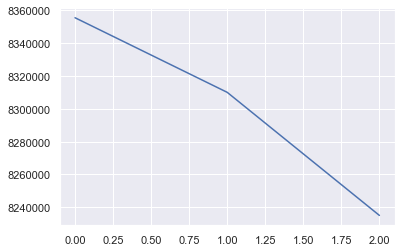

In [51]:
sns.set()
plt.plot(p)
plt.show()

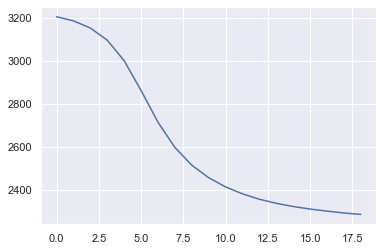

In [155]:
plt.plot(loss_l)

In [ ]:
import scipy.io as scio
 
dataFile = '..//data.mat'
data = scio.loadmat(dataFile)

In [167]:
import os
os.chdir('DirBN-master/data')

In [168]:
import scipy.io as scio
from scipy.sparse import csc_matrix
from scipy import sparse
dataFile = 'TMN.mat'
data = scio.loadmat(dataFile)

In [171]:
data['x']

<13370x32597 sparse matrix of type '<class 'numpy.float64'>'
	with 510583 stored elements in Compressed Sparse Column format>

In [194]:
sp = sparse.csr_matrix(data['x'].toarray())

In [203]:
for a in data['x']:
    print (a)

  (0, 0)	1.0
  (0, 7)	2.0
  (0, 8)	2.0
  (0, 32)	2.0
  (0, 50)	1.0
  (0, 86)	1.0
  (0, 98)	2.0
  (0, 100)	2.0
  (0, 104)	1.0
  (0, 110)	1.0
  (0, 118)	1.0
  (0, 154)	1.0
  (0, 205)	1.0
  (0, 211)	1.0
  (0, 257)	1.0
  (0, 274)	1.0
  (0, 379)	2.0
  (0, 482)	2.0
  (0, 567)	1.0
  (0, 628)	1.0
  (0, 641)	1.0
  (0, 677)	2.0
  (0, 722)	1.0
  (0, 733)	2.0
  (0, 831)	1.0
  :	:
  (0, 31482)	1.0
  (0, 31536)	2.0
  (0, 31576)	1.0
  (0, 31589)	2.0
  (0, 31673)	1.0
  (0, 31674)	1.0
  (0, 31768)	1.0
  (0, 31836)	1.0
  (0, 31882)	2.0
  (0, 31968)	2.0
  (0, 32126)	2.0
  (0, 32158)	2.0
  (0, 32168)	1.0
  (0, 32201)	1.0
  (0, 32204)	1.0
  (0, 32249)	2.0
  (0, 32253)	2.0
  (0, 32334)	2.0
  (0, 32416)	2.0
  (0, 32453)	2.0
  (0, 32456)	2.0
  (0, 32475)	1.0
  (0, 32486)	2.0
  (0, 32546)	1.0
  (0, 32549)	1.0
  (0, 0)	1.0
  (0, 1207)	1.0
  (0, 2945)	1.0
  (0, 6279)	1.0
  (0, 6457)	1.0
  (0, 8223)	1.0
  (0, 8616)	1.0
  (0, 9376)	1.0
  (0, 9932)	1.0
  (0, 11483)	1.0
  (0, 12702)	1.0
  (0, 13835)	1.0
  (0, 14004)

  (0, 15)	1.0
  (0, 26)	1.0
  (0, 745)	1.0
  (0, 1027)	1.0
  (0, 1503)	1.0
  (0, 1710)	1.0
  (0, 1715)	1.0
  (0, 1858)	1.0
  (0, 2102)	1.0
  (0, 2422)	1.0
  (0, 2563)	1.0
  (0, 2826)	1.0
  (0, 3008)	1.0
  (0, 3245)	1.0
  (0, 3479)	1.0
  (0, 3764)	1.0
  (0, 3955)	1.0
  (0, 4197)	1.0
  (0, 4229)	2.0
  (0, 4313)	1.0
  (0, 4507)	1.0
  (0, 4528)	1.0
  (0, 4705)	1.0
  (0, 4847)	1.0
  (0, 4929)	1.0
  :	:
  (0, 26736)	1.0
  (0, 27199)	1.0
  (0, 27324)	1.0
  (0, 27338)	1.0
  (0, 27992)	1.0
  (0, 28012)	1.0
  (0, 28219)	1.0
  (0, 28269)	1.0
  (0, 28301)	1.0
  (0, 28347)	1.0
  (0, 28360)	1.0
  (0, 28585)	1.0
  (0, 29023)	1.0
  (0, 29601)	1.0
  (0, 29616)	1.0
  (0, 30339)	1.0
  (0, 30476)	1.0
  (0, 30589)	1.0
  (0, 31010)	1.0
  (0, 31062)	1.0
  (0, 31092)	1.0
  (0, 31357)	1.0
  (0, 31456)	1.0
  (0, 31859)	1.0
  (0, 32338)	2.0
  (0, 15)	1.0
  (0, 120)	1.0
  (0, 134)	1.0
  (0, 139)	1.0
  (0, 211)	1.0
  (0, 323)	1.0
  (0, 324)	1.0
  (0, 357)	1.0
  (0, 432)	2.0
  (0, 558)	1.0
  (0, 693)	1.0
  (0, 779)

  (0, 37)	2.0
  (0, 489)	1.0
  (0, 771)	2.0
  (0, 872)	1.0
  (0, 1196)	2.0
  (0, 1387)	1.0
  (0, 1455)	1.0
  (0, 1733)	1.0
  (0, 1741)	1.0
  (0, 1885)	1.0
  (0, 2479)	1.0
  (0, 2617)	1.0
  (0, 2643)	1.0
  (0, 2824)	1.0
  (0, 2967)	1.0
  (0, 3595)	1.0
  (0, 3898)	2.0
  (0, 4062)	1.0
  (0, 4119)	1.0
  (0, 4610)	1.0
  (0, 4718)	2.0
  (0, 4972)	1.0
  (0, 5102)	1.0
  (0, 5121)	1.0
  (0, 5330)	1.0
  :	:
  (0, 27248)	1.0
  (0, 27393)	1.0
  (0, 27465)	1.0
  (0, 27488)	1.0
  (0, 27665)	1.0
  (0, 27921)	2.0
  (0, 28111)	2.0
  (0, 28149)	1.0
  (0, 28291)	1.0
  (0, 28371)	1.0
  (0, 28380)	1.0
  (0, 28691)	1.0
  (0, 28776)	1.0
  (0, 28995)	1.0
  (0, 29032)	1.0
  (0, 29773)	1.0
  (0, 30066)	1.0
  (0, 30206)	1.0
  (0, 30225)	1.0
  (0, 31328)	1.0
  (0, 31522)	1.0
  (0, 31575)	1.0
  (0, 31611)	1.0
  (0, 31645)	1.0
  (0, 32436)	1.0
  (0, 37)	1.0
  (0, 851)	2.0
  (0, 2561)	2.0
  (0, 11849)	2.0
  (0, 13019)	2.0
  (0, 15906)	2.0
  (0, 16103)	1.0
  (0, 16561)	2.0
  (0, 16631)	1.0
  (0, 17102)	2.0
  (0, 1714

  (0, 63)	1.0
  (0, 483)	1.0
  (0, 1101)	1.0
  (0, 1578)	1.0
  (0, 1746)	1.0
  (0, 1830)	1.0
  (0, 2225)	1.0
  (0, 2345)	1.0
  (0, 3389)	1.0
  (0, 3427)	1.0
  (0, 3734)	1.0
  (0, 3770)	1.0
  (0, 3933)	1.0
  (0, 4342)	1.0
  (0, 4343)	2.0
  (0, 4707)	1.0
  (0, 4888)	2.0
  (0, 5504)	1.0
  (0, 5893)	1.0
  (0, 6057)	1.0
  (0, 6237)	1.0
  (0, 6406)	1.0
  (0, 6520)	1.0
  (0, 6607)	1.0
  (0, 6982)	1.0
  :	:
  (0, 26300)	1.0
  (0, 26575)	2.0
  (0, 26762)	1.0
  (0, 26955)	1.0
  (0, 26956)	1.0
  (0, 27166)	1.0
  (0, 27828)	1.0
  (0, 28025)	2.0
  (0, 28150)	1.0
  (0, 28285)	2.0
  (0, 28493)	1.0
  (0, 28582)	1.0
  (0, 28926)	1.0
  (0, 29629)	1.0
  (0, 29660)	1.0
  (0, 29861)	1.0
  (0, 30473)	1.0
  (0, 30516)	1.0
  (0, 30608)	1.0
  (0, 30722)	1.0
  (0, 31132)	1.0
  (0, 31619)	1.0
  (0, 31754)	1.0
  (0, 32235)	1.0
  (0, 32484)	1.0
  (0, 63)	1.0
  (0, 222)	1.0
  (0, 357)	1.0
  (0, 370)	1.0
  (0, 463)	2.0
  (0, 512)	1.0
  (0, 609)	1.0
  (0, 689)	1.0
  (0, 727)	1.0
  (0, 743)	2.0
  (0, 958)	1.0
  (0, 10

  (0, 31526)	1.0
  (0, 97)	1.0
  (0, 751)	1.0
  (0, 903)	2.0
  (0, 1266)	1.0
  (0, 1674)	1.0
  (0, 2071)	2.0
  (0, 2931)	1.0
  (0, 3634)	1.0
  (0, 4207)	1.0
  (0, 4737)	1.0
  (0, 4782)	1.0
  (0, 4871)	1.0
  (0, 5069)	1.0
  (0, 5366)	1.0
  (0, 5667)	1.0
  (0, 6087)	3.0
  (0, 6230)	1.0
  (0, 6584)	1.0
  (0, 7222)	2.0
  (0, 7439)	1.0
  (0, 7454)	1.0
  (0, 7786)	1.0
  (0, 8068)	1.0
  (0, 8348)	1.0
  (0, 8492)	1.0
  :	:
  (0, 26529)	1.0
  (0, 26580)	1.0
  (0, 27260)	1.0
  (0, 27413)	1.0
  (0, 27467)	1.0
  (0, 27607)	2.0
  (0, 27621)	1.0
  (0, 27676)	1.0
  (0, 27886)	1.0
  (0, 27949)	1.0
  (0, 28437)	2.0
  (0, 28675)	1.0
  (0, 29086)	1.0
  (0, 29287)	1.0
  (0, 29795)	1.0
  (0, 30073)	1.0
  (0, 30155)	1.0
  (0, 30351)	2.0
  (0, 30866)	1.0
  (0, 31020)	1.0
  (0, 31457)	1.0
  (0, 31721)	1.0
  (0, 31803)	1.0
  (0, 31981)	1.0
  (0, 32507)	1.0
  (0, 97)	1.0
  (0, 337)	1.0
  (0, 527)	1.0
  (0, 869)	1.0
  (0, 873)	1.0
  (0, 2022)	1.0
  (0, 2305)	1.0
  (0, 2311)	1.0
  (0, 4072)	1.0
  (0, 4623)	1.0
  

  (0, 135)	1.0
  (0, 404)	2.0
  (0, 836)	1.0
  (0, 1225)	1.0
  (0, 1767)	1.0
  (0, 2073)	2.0
  (0, 2273)	1.0
  (0, 2345)	2.0
  (0, 3159)	1.0
  (0, 3395)	1.0
  (0, 4171)	1.0
  (0, 4190)	2.0
  (0, 4627)	1.0
  (0, 4888)	2.0
  (0, 5346)	1.0
  (0, 5693)	2.0
  (0, 6629)	1.0
  (0, 6781)	1.0
  (0, 7351)	2.0
  (0, 8421)	1.0
  (0, 8722)	1.0
  (0, 9729)	1.0
  (0, 10191)	1.0
  (0, 11222)	1.0
  (0, 12049)	1.0
  :	:
  (0, 23413)	1.0
  (0, 23681)	2.0
  (0, 23918)	1.0
  (0, 24088)	2.0
  (0, 24090)	2.0
  (0, 24976)	1.0
  (0, 25086)	1.0
  (0, 25157)	1.0
  (0, 25324)	1.0
  (0, 25490)	2.0
  (0, 25784)	1.0
  (0, 25813)	1.0
  (0, 25902)	2.0
  (0, 26733)	2.0
  (0, 27058)	1.0
  (0, 27320)	2.0
  (0, 27906)	1.0
  (0, 27932)	1.0
  (0, 28733)	1.0
  (0, 29169)	1.0
  (0, 30516)	1.0
  (0, 31974)	1.0
  (0, 32281)	1.0
  (0, 32324)	1.0
  (0, 32582)	1.0
  (0, 135)	1.0
  (0, 171)	1.0
  (0, 451)	2.0
  (0, 582)	1.0
  (0, 590)	1.0
  (0, 676)	1.0
  (0, 801)	1.0
  (0, 823)	2.0
  (0, 848)	1.0
  (0, 859)	1.0
  (0, 906)	1.0
  (0

  (0, 31973)	1.0
  (0, 178)	1.0
  (0, 325)	1.0
  (0, 3278)	1.0
  (0, 3353)	1.0
  (0, 8020)	1.0
  (0, 8951)	1.0
  (0, 8955)	1.0
  (0, 8988)	1.0
  (0, 9199)	1.0
  (0, 10598)	1.0
  (0, 11477)	1.0
  (0, 11666)	1.0
  (0, 15748)	1.0
  (0, 22767)	1.0
  (0, 30745)	1.0
  (0, 31941)	1.0
  (0, 178)	1.0
  (0, 1929)	1.0
  (0, 3013)	1.0
  (0, 3999)	1.0
  (0, 4469)	1.0
  (0, 6181)	1.0
  (0, 6189)	1.0
  (0, 6288)	1.0
  (0, 7026)	1.0
  (0, 7028)	1.0
  (0, 7434)	1.0
  (0, 8472)	1.0
  (0, 9418)	1.0
  (0, 9731)	1.0
  (0, 10784)	1.0
  (0, 11575)	1.0
  (0, 13130)	1.0
  (0, 13482)	1.0
  (0, 15863)	1.0
  (0, 16574)	1.0
  (0, 16673)	1.0
  (0, 18536)	1.0
  (0, 18693)	1.0
  (0, 18886)	1.0
  (0, 19100)	1.0
  (0, 20666)	1.0
  (0, 20679)	1.0
  (0, 21594)	1.0
  (0, 24495)	1.0
  (0, 24974)	1.0
  (0, 25169)	1.0
  (0, 27697)	1.0
  (0, 28386)	1.0
  (0, 31380)	1.0
  (0, 178)	1.0
  (0, 4879)	1.0
  (0, 8562)	1.0
  (0, 8781)	1.0
  (0, 9389)	1.0
  (0, 13989)	1.0
  (0, 13990)	1.0
  (0, 17085)	1.0
  (0, 18886)	1.0
  (0, 23841)

  (0, 222)	2.0
  (0, 5024)	1.0
  (0, 13797)	1.0
  (0, 18884)	2.0
  (0, 26014)	2.0
  (0, 28289)	2.0
  (0, 31464)	2.0
  (0, 222)	1.0
  (0, 491)	1.0
  (0, 12361)	1.0
  (0, 13517)	1.0
  (0, 28504)	1.0
  (0, 222)	1.0
  (0, 774)	1.0
  (0, 1022)	1.0
  (0, 5720)	1.0
  (0, 7394)	1.0
  (0, 222)	1.0
  (0, 1005)	1.0
  (0, 1058)	1.0
  (0, 1085)	1.0
  (0, 1353)	1.0
  (0, 1476)	1.0
  (0, 1489)	1.0
  (0, 1537)	1.0
  (0, 1654)	1.0
  (0, 1680)	1.0
  (0, 1818)	1.0
  (0, 1819)	2.0
  (0, 1857)	2.0
  (0, 1931)	1.0
  (0, 1946)	1.0
  (0, 2017)	1.0
  (0, 2402)	1.0
  (0, 2609)	1.0
  (0, 2881)	1.0
  (0, 3116)	1.0
  (0, 3422)	1.0
  (0, 3613)	1.0
  (0, 3757)	1.0
  (0, 3908)	1.0
  (0, 4224)	1.0
  :	:
  (0, 28982)	1.0
  (0, 29178)	1.0
  (0, 29476)	1.0
  (0, 29479)	1.0
  (0, 29487)	1.0
  (0, 29650)	1.0
  (0, 29656)	1.0
  (0, 29884)	1.0
  (0, 30318)	1.0
  (0, 30395)	1.0
  (0, 30459)	1.0
  (0, 30645)	1.0
  (0, 30693)	1.0
  (0, 30826)	1.0
  (0, 30910)	1.0
  (0, 30956)	1.0
  (0, 31105)	1.0
  (0, 31319)	1.0
  (0, 31769)	1

  (0, 32305)	1.0
  (0, 279)	1.0
  (0, 513)	1.0
  (0, 1047)	1.0
  (0, 1130)	1.0
  (0, 1353)	1.0
  (0, 2901)	1.0
  (0, 3074)	1.0
  (0, 4041)	1.0
  (0, 5121)	1.0
  (0, 5226)	1.0
  (0, 5242)	1.0
  (0, 5295)	1.0
  (0, 5363)	1.0
  (0, 5477)	1.0
  (0, 5710)	1.0
  (0, 6042)	1.0
  (0, 6309)	1.0
  (0, 6502)	1.0
  (0, 6637)	1.0
  (0, 6692)	1.0
  (0, 7762)	1.0
  (0, 8045)	1.0
  (0, 8198)	1.0
  (0, 8209)	1.0
  (0, 9458)	1.0
  :	:
  (0, 11533)	2.0
  (0, 11720)	1.0
  (0, 15140)	1.0
  (0, 16793)	1.0
  (0, 16895)	1.0
  (0, 18175)	1.0
  (0, 18372)	1.0
  (0, 19944)	1.0
  (0, 20156)	1.0
  (0, 20653)	1.0
  (0, 21978)	1.0
  (0, 23184)	1.0
  (0, 23736)	1.0
  (0, 24253)	1.0
  (0, 24312)	2.0
  (0, 25374)	1.0
  (0, 25624)	1.0
  (0, 29521)	1.0
  (0, 29946)	1.0
  (0, 29994)	1.0
  (0, 30147)	1.0
  (0, 30365)	1.0
  (0, 30579)	1.0
  (0, 30955)	3.0
  (0, 32278)	1.0
  (0, 279)	1.0
  (0, 2861)	1.0
  (0, 19091)	2.0
  (0, 21208)	1.0
  (0, 279)	1.0
  (0, 2354)	1.0
  (0, 3697)	1.0
  (0, 3702)	1.0
  (0, 3764)	1.0
  (0, 4937

  (0, 327)	1.0
  (0, 1218)	1.0
  (0, 1903)	2.0
  (0, 2622)	1.0
  (0, 4240)	1.0
  (0, 6647)	1.0
  (0, 7899)	1.0
  (0, 10416)	1.0
  (0, 10775)	1.0
  (0, 11611)	1.0
  (0, 12600)	1.0
  (0, 12820)	1.0
  (0, 14155)	1.0
  (0, 15799)	1.0
  (0, 16850)	1.0
  (0, 19531)	1.0
  (0, 21848)	1.0
  (0, 22787)	1.0
  (0, 23866)	1.0
  (0, 24238)	1.0
  (0, 25508)	1.0
  (0, 25637)	1.0
  (0, 25687)	1.0
  (0, 27933)	1.0
  (0, 29724)	1.0
  (0, 31047)	1.0
  (0, 31583)	1.0
  (0, 31861)	1.0
  (0, 327)	1.0
  (0, 1172)	1.0
  (0, 2647)	1.0
  (0, 29038)	1.0
  (0, 30036)	1.0
  (0, 328)	2.0
  (0, 8659)	1.0
  (0, 11633)	2.0
  (0, 16822)	2.0
  (0, 27171)	2.0
  (0, 31318)	2.0
  (0, 328)	1.0
  (0, 375)	1.0
  (0, 913)	1.0
  (0, 1008)	1.0
  (0, 1254)	1.0
  (0, 1516)	1.0
  (0, 1935)	1.0
  (0, 2544)	1.0
  (0, 2545)	1.0
  (0, 2772)	1.0
  (0, 2891)	1.0
  (0, 3010)	1.0
  (0, 3084)	1.0
  (0, 3388)	1.0
  (0, 3574)	1.0
  (0, 3894)	1.0
  (0, 3968)	1.0
  (0, 4150)	1.0
  (0, 4178)	1.0
  (0, 4217)	1.0
  (0, 4224)	2.0
  (0, 4254)	1.0
  (

  (0, 399)	1.0
  (0, 17590)	2.0
  (0, 28213)	2.0
  (0, 399)	1.0
  (0, 2725)	2.0
  (0, 3543)	1.0
  (0, 4469)	1.0
  (0, 6941)	1.0
  (0, 9179)	1.0
  (0, 12235)	1.0
  (0, 17167)	2.0
  (0, 17589)	1.0
  (0, 21045)	1.0
  (0, 22203)	1.0
  (0, 25126)	1.0
  (0, 25468)	1.0
  (0, 28064)	1.0
  (0, 30528)	2.0
  (0, 399)	1.0
  (0, 2725)	2.0
  (0, 3543)	1.0
  (0, 4469)	1.0
  (0, 6941)	1.0
  (0, 9179)	1.0
  (0, 12235)	1.0
  (0, 17167)	2.0
  (0, 17589)	1.0
  (0, 21045)	1.0
  (0, 22203)	1.0
  (0, 25126)	1.0
  (0, 25468)	1.0
  (0, 28064)	1.0
  (0, 30528)	1.0
  (0, 400)	2.0
  (0, 1252)	2.0
  (0, 4734)	1.0
  (0, 9616)	1.0
  (0, 9745)	2.0
  (0, 15222)	2.0
  (0, 20964)	1.0
  (0, 21322)	1.0
  (0, 22320)	2.0
  (0, 22667)	1.0
  (0, 27977)	1.0
  (0, 31978)	1.0
  (0, 400)	2.0
  (0, 5401)	2.0
  (0, 9745)	1.0
  (0, 11886)	1.0
  (0, 11972)	2.0
  (0, 12184)	1.0
  (0, 21388)	1.0
  (0, 24446)	1.0
  (0, 26313)	1.0
  (0, 27287)	1.0
  (0, 31459)	2.0
  (0, 400)	1.0
  (0, 441)	1.0
  (0, 498)	2.0
  (0, 603)	1.0
  (0, 760)	1.0

  (0, 32584)	1.0
  (0, 455)	1.0
  (0, 1207)	2.0
  (0, 1258)	1.0
  (0, 1318)	2.0
  (0, 1909)	1.0
  (0, 2330)	1.0
  (0, 2712)	1.0
  (0, 2714)	1.0
  (0, 3408)	1.0
  (0, 3467)	1.0
  (0, 3608)	1.0
  (0, 3619)	1.0
  (0, 4344)	1.0
  (0, 5077)	1.0
  (0, 5186)	2.0
  (0, 5437)	2.0
  (0, 5709)	1.0
  (0, 5714)	1.0
  (0, 7195)	1.0
  (0, 7470)	2.0
  (0, 8343)	1.0
  (0, 8777)	1.0
  (0, 8832)	1.0
  (0, 9234)	2.0
  (0, 9340)	2.0
  :	:
  (0, 23514)	2.0
  (0, 23548)	2.0
  (0, 23947)	2.0
  (0, 24424)	1.0
  (0, 25369)	1.0
  (0, 27192)	1.0
  (0, 27531)	1.0
  (0, 27982)	1.0
  (0, 28046)	1.0
  (0, 28058)	1.0
  (0, 28401)	1.0
  (0, 28412)	1.0
  (0, 29047)	1.0
  (0, 29532)	1.0
  (0, 29568)	1.0
  (0, 30525)	1.0
  (0, 30976)	1.0
  (0, 31069)	1.0
  (0, 31084)	2.0
  (0, 31118)	1.0
  (0, 31182)	1.0
  (0, 31438)	1.0
  (0, 31455)	1.0
  (0, 31730)	2.0
  (0, 32503)	2.0
  (0, 455)	1.0
  (0, 480)	1.0
  (0, 513)	1.0
  (0, 589)	1.0
  (0, 1038)	1.0
  (0, 1319)	1.0
  (0, 1447)	1.0
  (0, 1448)	1.0
  (0, 1814)	1.0
  (0, 1868)	1

  (0, 518)	2.0
  (0, 995)	1.0
  (0, 996)	2.0
  (0, 1031)	1.0
  (0, 3319)	1.0
  (0, 3429)	2.0
  (0, 4030)	2.0
  (0, 4754)	1.0
  (0, 5879)	1.0
  (0, 7178)	1.0
  (0, 7755)	2.0
  (0, 10238)	2.0
  (0, 10821)	1.0
  (0, 11451)	2.0
  (0, 12061)	1.0
  (0, 16378)	1.0
  (0, 18526)	1.0
  (0, 18527)	1.0
  (0, 19813)	1.0
  (0, 19988)	1.0
  (0, 20138)	1.0
  (0, 21809)	1.0
  (0, 22168)	2.0
  (0, 23127)	2.0
  (0, 23670)	1.0
  (0, 25442)	1.0
  (0, 25549)	1.0
  (0, 25567)	1.0
  (0, 25581)	1.0
  (0, 25582)	1.0
  (0, 25583)	1.0
  (0, 25584)	1.0
  (0, 25860)	1.0
  (0, 26221)	2.0
  (0, 27496)	2.0
  (0, 28780)	1.0
  (0, 28797)	1.0
  (0, 29155)	1.0
  (0, 31286)	2.0
  (0, 31622)	1.0
  (0, 32029)	1.0
  (0, 32465)	2.0
  (0, 518)	2.0
  (0, 5070)	1.0
  (0, 5106)	1.0
  (0, 5515)	1.0
  (0, 7895)	1.0
  (0, 8319)	1.0
  (0, 9955)	1.0
  (0, 11648)	1.0
  (0, 12812)	2.0
  (0, 19750)	1.0
  (0, 20361)	2.0
  (0, 21865)	1.0
  (0, 25589)	1.0
  (0, 25805)	1.0
  (0, 26092)	1.0
  (0, 28004)	1.0
  (0, 29487)	1.0
  (0, 32029)	1.0
  

  (0, 32515)	1.0
  (0, 622)	1.0
  (0, 805)	1.0
  (0, 1096)	1.0
  (0, 1600)	1.0
  (0, 1816)	2.0
  (0, 2195)	1.0
  (0, 2417)	2.0
  (0, 2786)	1.0
  (0, 3242)	1.0
  (0, 3351)	1.0
  (0, 3418)	1.0
  (0, 3433)	2.0
  (0, 3436)	1.0
  (0, 3528)	1.0
  (0, 4064)	1.0
  (0, 4442)	1.0
  (0, 4635)	1.0
  (0, 4658)	1.0
  (0, 5137)	1.0
  (0, 5981)	1.0
  (0, 6346)	1.0
  (0, 6386)	1.0
  (0, 6757)	1.0
  (0, 7817)	1.0
  (0, 7861)	1.0
  :	:
  (0, 25419)	1.0
  (0, 25465)	2.0
  (0, 25911)	1.0
  (0, 25993)	1.0
  (0, 26043)	1.0
  (0, 26309)	1.0
  (0, 26765)	1.0
  (0, 27110)	1.0
  (0, 28031)	1.0
  (0, 28075)	1.0
  (0, 28085)	1.0
  (0, 28766)	1.0
  (0, 29135)	1.0
  (0, 29334)	1.0
  (0, 29476)	1.0
  (0, 29580)	1.0
  (0, 29709)	1.0
  (0, 29974)	1.0
  (0, 30960)	1.0
  (0, 31163)	1.0
  (0, 31432)	1.0
  (0, 31471)	1.0
  (0, 32001)	1.0
  (0, 32098)	1.0
  (0, 32336)	2.0
  (0, 622)	1.0
  (0, 986)	1.0
  (0, 1222)	1.0
  (0, 1426)	1.0
  (0, 1631)	1.0
  (0, 3090)	1.0
  (0, 3539)	1.0
  (0, 3688)	1.0
  (0, 6291)	1.0
  (0, 6479)	

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  (0, 1071)	2.0
  (0, 2515)	1.0
  (0, 2527)	1.0
  (0, 3187)	1.0
  (0, 3203)	1.0
  (0, 5021)	1.0
  (0, 6216)	1.0
  (0, 6256)	1.0
  (0, 7659)	1.0
  (0, 11074)	1.0
  (0, 12098)	1.0
  (0, 12367)	2.0
  (0, 12457)	1.0
  (0, 12957)	1.0
  (0, 16284)	1.0
  (0, 16722)	2.0
  (0, 17007)	1.0
  (0, 17297)	1.0
  (0, 18019)	1.0
  (0, 19565)	2.0
  (0, 20463)	1.0
  (0, 20921)	1.0
  (0, 22132)	1.0
  (0, 25298)	1.0
  (0, 25313)	1.0
  (0, 27637)	1.0
  (0, 29258)	1.0
  (0, 29445)	1.0
  (0, 30813)	1.0
  (0, 1071)	2.0
  (0, 1949)	2.0
  (0, 3057)	2.0
  (0, 3602)	2.0
  (0, 3633)	2.0
  (0, 3950)	2.0
  (0, 5325)	1.0
  (0, 6216)	2.0
  (0, 6860)	1.0
  (0, 6879)	1.0
  (0, 7982)	1.0
  (0, 9122)	2.0
  (0, 10912)	2.0
  (0, 12623)	1.0
  (0, 13076)	1.0
  (0, 14965)	1.0
  (0, 16530)	2.0
  (0, 16883)	1.0
  (0, 17465)	1.0
  (0, 18662)	2.0
  (0, 19217)	1.0
  (0, 19481)	1.0
  (0, 20054)	2.0
  (0, 20354)	1.0
  (0, 20964)	1.0
  (0, 21042)	1.0
  (0, 21046)	2.0
  (0, 21054)	1.0
  (0, 21726)	1.0
  (0, 22320)	1.0
  (0, 26405)	1.0
 

  (0, 31949)	1.0
  (0, 1178)	1.0
  (0, 3486)	1.0
  (0, 3650)	1.0
  (0, 3977)	2.0
  (0, 5199)	1.0
  (0, 6132)	1.0
  (0, 6385)	1.0
  (0, 7979)	2.0
  (0, 8202)	1.0
  (0, 8564)	1.0
  (0, 10006)	1.0
  (0, 11177)	2.0
  (0, 13073)	1.0
  (0, 13622)	1.0
  (0, 13760)	2.0
  (0, 14074)	1.0
  (0, 14408)	2.0
  (0, 15482)	1.0
  (0, 16576)	1.0
  (0, 16698)	1.0
  (0, 18514)	2.0
  (0, 19636)	1.0
  (0, 19773)	2.0
  (0, 22477)	1.0
  (0, 23213)	1.0
  (0, 27034)	2.0
  (0, 27553)	1.0
  (0, 28595)	1.0
  (0, 28999)	1.0
  (0, 29544)	2.0
  (0, 31666)	1.0
  (0, 31668)	2.0
  (0, 31737)	1.0
  (0, 31895)	2.0
  (0, 32418)	1.0
  (0, 32515)	1.0
  (0, 1178)	1.0
  (0, 1281)	1.0
  (0, 1366)	1.0
  (0, 6561)	2.0
  (0, 27843)	1.0
  (0, 1178)	1.0
  (0, 8617)	1.0
  (0, 14888)	1.0
  (0, 18203)	1.0
  (0, 21023)	1.0
  (0, 22684)	1.0
  (0, 31466)	1.0
  (0, 1179)	1.0
  (0, 3598)	1.0
  (0, 6593)	1.0
  (0, 14934)	1.0
  (0, 21223)	1.0
  (0, 21735)	1.0
  (0, 30031)	1.0
  (0, 1180)	2.0
  (0, 1567)	3.0
  (0, 1807)	1.0
  (0, 2184)	1.0
  (

  (0, 1329)	1.0
  (0, 1658)	1.0
  (0, 1815)	1.0
  (0, 3284)	1.0
  (0, 6010)	1.0
  (0, 7700)	1.0
  (0, 11526)	1.0
  (0, 12365)	1.0
  (0, 13527)	1.0
  (0, 14982)	1.0
  (0, 17906)	1.0
  (0, 20114)	1.0
  (0, 20878)	1.0
  (0, 21677)	1.0
  (0, 25013)	1.0
  (0, 27483)	1.0
  (0, 27486)	1.0
  (0, 27664)	1.0
  (0, 28154)	1.0
  (0, 29780)	1.0
  (0, 32027)	1.0
  (0, 1329)	1.0
  (0, 3379)	1.0
  (0, 5257)	1.0
  (0, 6984)	1.0
  (0, 6985)	1.0
  (0, 7339)	1.0
  (0, 7714)	1.0
  (0, 8434)	1.0
  (0, 10981)	1.0
  (0, 12034)	1.0
  (0, 13346)	1.0
  (0, 13845)	1.0
  (0, 18042)	1.0
  (0, 27384)	1.0
  (0, 30616)	1.0
  (0, 1329)	1.0
  (0, 9381)	2.0
  (0, 12389)	1.0
  (0, 22527)	1.0
  (0, 27384)	1.0
  (0, 28686)	1.0
  (0, 31731)	1.0
  (0, 1330)	2.0
  (0, 2189)	2.0
  (0, 3016)	2.0
  (0, 4052)	2.0
  (0, 5833)	1.0
  (0, 8082)	2.0
  (0, 8385)	2.0
  (0, 9042)	1.0
  (0, 13045)	2.0
  (0, 13629)	1.0
  (0, 19979)	2.0
  (0, 20837)	1.0
  (0, 21352)	1.0
  (0, 21400)	1.0
  (0, 22398)	2.0
  (0, 24007)	1.0
  (0, 24786)	1.0
  (0

  (0, 1506)	1.0
  (0, 4876)	1.0
  (0, 8036)	1.0
  (0, 27457)	1.0
  (0, 30071)	1.0
  (0, 1506)	1.0
  (0, 5913)	2.0
  (0, 7378)	2.0
  (0, 7483)	2.0
  (0, 21355)	1.0
  (0, 23850)	1.0
  (0, 28588)	1.0
  (0, 30071)	1.0
  (0, 1506)	1.0
  (0, 2064)	1.0
  (0, 6935)	1.0
  (0, 6940)	1.0
  (0, 20767)	1.0
  (0, 23284)	1.0
  (0, 27980)	1.0
  (0, 30071)	1.0
  (0, 30400)	1.0
  (0, 1507)	1.0
  (0, 2541)	1.0
  (0, 8913)	1.0
  (0, 12505)	1.0
  (0, 13816)	1.0
  (0, 17119)	1.0
  (0, 17126)	1.0
  (0, 28040)	1.0
  (0, 30696)	1.0
  (0, 31994)	1.0
  (0, 1507)	1.0
  (0, 1540)	1.0
  (0, 1753)	1.0
  (0, 1823)	1.0
  (0, 1827)	1.0
  (0, 3576)	1.0
  (0, 3725)	1.0
  (0, 4799)	2.0
  (0, 4866)	1.0
  (0, 6943)	2.0
  (0, 8608)	1.0
  (0, 8965)	1.0
  (0, 11465)	1.0
  (0, 11661)	1.0
  (0, 15252)	2.0
  (0, 15253)	2.0
  (0, 16231)	2.0
  (0, 17059)	1.0
  (0, 18661)	1.0
  (0, 18838)	1.0
  (0, 19096)	1.0
  (0, 19365)	1.0
  (0, 23052)	1.0
  (0, 25126)	1.0
  (0, 25815)	1.0
  (0, 26016)	1.0
  (0, 27075)	1.0
  (0, 27775)	1.0
  (0, 

  (0, 1694)	1.0
  (0, 1722)	2.0
  (0, 1884)	2.0
  (0, 2738)	1.0
  (0, 5967)	1.0
  (0, 6586)	1.0
  (0, 7254)	1.0
  (0, 12968)	1.0
  (0, 18784)	1.0
  (0, 20934)	1.0
  (0, 22177)	2.0
  (0, 23439)	1.0
  (0, 24473)	1.0
  (0, 25753)	1.0
  (0, 28492)	1.0
  (0, 1696)	2.0
  (0, 2965)	1.0
  (0, 2986)	3.0
  (0, 3340)	1.0
  (0, 7547)	1.0
  (0, 7997)	1.0
  (0, 8135)	1.0
  (0, 8151)	1.0
  (0, 11408)	1.0
  (0, 20230)	1.0
  (0, 22246)	2.0
  (0, 25868)	2.0
  (0, 31314)	1.0
  (0, 31658)	2.0
  (0, 1696)	2.0
  (0, 3161)	2.0
  (0, 3163)	2.0
  (0, 5285)	2.0
  (0, 6091)	1.0
  (0, 6155)	3.0
  (0, 9770)	1.0
  (0, 11408)	1.0
  (0, 11675)	1.0
  (0, 13597)	1.0
  (0, 14317)	3.0
  (0, 17499)	1.0
  (0, 20230)	1.0
  (0, 22246)	2.0
  (0, 24474)	2.0
  (0, 25868)	2.0
  (0, 26828)	2.0
  (0, 29453)	1.0
  (0, 31658)	2.0
  (0, 1697)	1.0
  (0, 8912)	1.0
  (0, 9089)	1.0
  (0, 11450)	1.0
  (0, 13890)	1.0
  (0, 21803)	1.0
  (0, 21967)	1.0
  (0, 25209)	1.0
  (0, 1697)	1.0
  (0, 8241)	1.0
  (0, 11450)	1.0
  (0, 12070)	1.0
  (0, 3

  (0, 1874)	2.0
  (0, 23222)	1.0
  (0, 28679)	2.0
  (0, 1875)	1.0
  (0, 6108)	1.0
  (0, 7469)	1.0
  (0, 10407)	1.0
  (0, 11393)	1.0
  (0, 11693)	1.0
  (0, 18800)	1.0
  (0, 23069)	1.0
  (0, 25899)	1.0
  (0, 26202)	1.0
  (0, 27053)	1.0
  (0, 28760)	1.0
  (0, 29596)	1.0
  (0, 31841)	2.0
  (0, 1876)	1.0
  (0, 2169)	1.0
  (0, 6704)	1.0
  (0, 7742)	1.0
  (0, 9629)	1.0
  (0, 14079)	1.0
  (0, 15332)	1.0
  (0, 15364)	1.0
  (0, 16560)	1.0
  (0, 17223)	1.0
  (0, 20274)	1.0
  (0, 20763)	1.0
  (0, 21794)	1.0
  (0, 24417)	1.0
  (0, 27416)	1.0
  (0, 28544)	1.0
  (0, 29189)	1.0
  (0, 29847)	1.0
  (0, 1877)	1.0
  (0, 3095)	1.0
  (0, 3116)	2.0
  (0, 4527)	1.0
  (0, 6653)	2.0
  (0, 7303)	2.0
  (0, 10400)	1.0
  (0, 11592)	1.0
  (0, 13594)	1.0
  (0, 14891)	1.0
  (0, 18388)	1.0
  (0, 18649)	2.0
  (0, 19113)	1.0
  (0, 20511)	2.0
  (0, 22919)	1.0
  (0, 23083)	1.0
  (0, 23159)	1.0
  (0, 24893)	1.0
  (0, 24929)	2.0
  (0, 25454)	1.0
  (0, 26288)	1.0
  (0, 27712)	1.0
  (0, 28164)	1.0
  (0, 28719)	1.0
  (0, 30115)

  (0, 2077)	1.0
  (0, 3869)	1.0
  (0, 8867)	1.0
  (0, 11106)	2.0
  (0, 15588)	1.0
  (0, 16132)	1.0
  (0, 19216)	1.0
  (0, 20303)	1.0
  (0, 21996)	1.0
  (0, 24701)	1.0
  (0, 2077)	1.0
  (0, 9833)	2.0
  (0, 11112)	1.0
  (0, 11312)	1.0
  (0, 17939)	1.0
  (0, 20183)	1.0
  (0, 20533)	1.0
  (0, 21624)	1.0
  (0, 22019)	1.0
  (0, 22889)	1.0
  (0, 23543)	1.0
  (0, 26260)	1.0
  (0, 28403)	1.0
  (0, 28479)	1.0
  (0, 29824)	1.0
  (0, 30239)	1.0
  (0, 30311)	1.0
  (0, 30875)	1.0
  (0, 2078)	1.0
  (0, 5064)	1.0
  (0, 6702)	1.0
  (0, 7722)	1.0
  (0, 8585)	1.0
  (0, 18934)	1.0
  (0, 26795)	1.0
  (0, 26969)	1.0
  (0, 2078)	1.0
  (0, 5192)	1.0
  (0, 19827)	1.0
  (0, 21336)	1.0
  (0, 22534)	1.0
  (0, 2079)	1.0
  (0, 3045)	1.0
  (0, 3205)	1.0
  (0, 4817)	1.0
  (0, 7505)	1.0
  (0, 8676)	1.0
  (0, 9044)	1.0
  (0, 21601)	2.0
  (0, 22293)	2.0
  (0, 26794)	1.0
  (0, 29522)	1.0
  (0, 32427)	1.0
  (0, 2079)	1.0
  (0, 2676)	1.0
  (0, 2835)	1.0
  (0, 7965)	1.0
  (0, 8333)	1.0
  (0, 10164)	1.0
  (0, 12904)	1.0
  (0

  (0, 23141)	2.0
  (0, 2276)	1.0
  (0, 2353)	1.0
  (0, 5142)	1.0
  (0, 5568)	1.0
  (0, 6073)	2.0
  (0, 8432)	1.0
  (0, 11554)	1.0
  (0, 14030)	1.0
  (0, 18866)	1.0
  (0, 18879)	1.0
  (0, 19754)	1.0
  (0, 20429)	1.0
  (0, 24856)	1.0
  (0, 24860)	1.0
  (0, 24885)	1.0
  (0, 27123)	1.0
  (0, 27298)	1.0
  (0, 28358)	1.0
  (0, 31653)	1.0
  (0, 2276)	1.0
  (0, 2356)	1.0
  (0, 2754)	1.0
  (0, 2755)	1.0
  (0, 2931)	1.0
  (0, 6174)	1.0
  (0, 7004)	1.0
  (0, 7915)	1.0
  (0, 7987)	1.0
  (0, 7998)	1.0
  (0, 8770)	1.0
  (0, 11950)	1.0
  (0, 12347)	1.0
  (0, 12357)	1.0
  (0, 12773)	1.0
  (0, 13187)	1.0
  (0, 15303)	1.0
  (0, 16164)	1.0
  (0, 17081)	1.0
  (0, 17192)	1.0
  (0, 18131)	1.0
  (0, 18554)	1.0
  (0, 19087)	1.0
  (0, 20261)	1.0
  (0, 20522)	1.0
  (0, 22578)	1.0
  (0, 23533)	1.0
  (0, 25163)	1.0
  (0, 26430)	1.0
  (0, 26679)	1.0
  (0, 26952)	1.0
  (0, 27225)	1.0
  (0, 27348)	1.0
  (0, 27477)	1.0
  (0, 28085)	1.0
  (0, 29064)	1.0
  (0, 29819)	1.0
  (0, 30046)	1.0
  (0, 30213)	1.0
  (0, 31206)	1

  (0, 30180)	1.0
  (0, 2546)	2.0
  (0, 2845)	2.0
  (0, 13184)	2.0
  (0, 17967)	1.0
  (0, 18404)	2.0
  (0, 25231)	2.0
  (0, 25232)	2.0
  (0, 25682)	2.0
  (0, 2547)	2.0
  (0, 5622)	1.0
  (0, 13035)	2.0
  (0, 16638)	1.0
  (0, 23482)	1.0
  (0, 25700)	2.0
  (0, 27641)	1.0
  (0, 2547)	2.0
  (0, 2979)	1.0
  (0, 3730)	1.0
  (0, 5992)	1.0
  (0, 7127)	1.0
  (0, 7752)	1.0
  (0, 9000)	1.0
  (0, 10069)	1.0
  (0, 15011)	1.0
  (0, 15977)	1.0
  (0, 17784)	1.0
  (0, 19516)	1.0
  (0, 21587)	1.0
  (0, 21843)	1.0
  (0, 24314)	2.0
  (0, 25016)	2.0
  (0, 25149)	1.0
  (0, 28149)	1.0
  (0, 29807)	1.0
  (0, 30268)	1.0
  (0, 30418)	2.0
  (0, 32500)	1.0
  (0, 2549)	2.0
  (0, 10941)	1.0
  (0, 13859)	2.0
  (0, 15682)	2.0
  (0, 16397)	1.0
  (0, 22268)	2.0
  (0, 22645)	1.0
  (0, 22735)	1.0
  (0, 32520)	1.0
  (0, 2549)	1.0
  (0, 2787)	1.0
  (0, 6028)	1.0
  (0, 7956)	1.0
  (0, 9238)	1.0
  (0, 10202)	1.0
  (0, 12481)	1.0
  (0, 13364)	1.0
  (0, 18475)	1.0
  (0, 18477)	1.0
  (0, 19187)	1.0
  (0, 19526)	1.0
  (0, 19671)	1

  (0, 2818)	1.0
  (0, 19043)	1.0
  (0, 23435)	1.0
  (0, 29273)	1.0
  (0, 29558)	1.0
  (0, 2819)	2.0
  (0, 5645)	1.0
  (0, 6027)	1.0
  (0, 15140)	1.0
  (0, 15702)	1.0
  (0, 17834)	1.0
  (0, 20885)	1.0
  (0, 21522)	1.0
  (0, 21974)	1.0
  (0, 25545)	1.0
  (0, 28676)	1.0
  (0, 29081)	1.0
  (0, 29678)	1.0
  (0, 30437)	1.0
  (0, 30712)	1.0
  (0, 30906)	1.0
  (0, 2819)	1.0
  (0, 4523)	1.0
  (0, 6537)	2.0
  (0, 11509)	1.0
  (0, 11688)	1.0
  (0, 15183)	1.0
  (0, 16712)	1.0
  (0, 16902)	2.0
  (0, 17753)	1.0
  (0, 18388)	1.0
  (0, 18992)	1.0
  (0, 18996)	1.0
  (0, 19229)	1.0
  (0, 21548)	1.0
  (0, 24452)	1.0
  (0, 24899)	1.0
  (0, 24901)	1.0
  (0, 26369)	2.0
  (0, 28589)	2.0
  (0, 30543)	1.0
  (0, 30723)	1.0
  (0, 2819)	1.0
  (0, 7267)	1.0
  (0, 19227)	1.0
  (0, 23394)	1.0
  (0, 26740)	1.0
  (0, 29296)	1.0
  (0, 2820)	2.0
  (0, 5414)	1.0
  (0, 6480)	1.0
  (0, 14983)	2.0
  (0, 16612)	1.0
  (0, 30776)	1.0
  (0, 30805)	1.0
  (0, 2820)	1.0
  (0, 9027)	1.0
  (0, 10711)	1.0
  (0, 23705)	1.0
  (0, 30162

  (0, 3152)	1.0
  (0, 7660)	1.0
  (0, 8136)	1.0
  (0, 8734)	1.0
  (0, 10663)	1.0
  (0, 14195)	2.0
  (0, 28239)	1.0
  (0, 3152)	3.0
  (0, 4559)	1.0
  (0, 6115)	2.0
  (0, 3155)	1.0
  (0, 7089)	2.0
  (0, 15804)	1.0
  (0, 16801)	1.0
  (0, 20713)	1.0
  (0, 24655)	1.0
  (0, 31629)	1.0
  (0, 3156)	1.0
  (0, 14809)	1.0
  (0, 17985)	1.0
  (0, 18176)	1.0
  (0, 28915)	1.0
  (0, 3156)	1.0
  (0, 9168)	1.0
  (0, 9255)	1.0
  (0, 11883)	1.0
  (0, 14332)	1.0
  (0, 16311)	1.0
  (0, 16731)	1.0
  (0, 17885)	1.0
  (0, 19223)	1.0
  (0, 19327)	2.0
  (0, 20840)	1.0
  (0, 24702)	1.0
  (0, 24879)	1.0
  (0, 27206)	1.0
  (0, 27662)	2.0
  (0, 31099)	1.0
  (0, 31683)	1.0
  (0, 3156)	1.0
  (0, 3202)	1.0
  (0, 4439)	1.0
  (0, 6599)	1.0
  (0, 7456)	1.0
  (0, 9234)	1.0
  (0, 9659)	1.0
  (0, 12675)	1.0
  (0, 12700)	1.0
  (0, 13817)	1.0
  (0, 17437)	1.0
  (0, 17531)	1.0
  (0, 19626)	1.0
  (0, 21409)	1.0
  (0, 22361)	1.0
  (0, 25474)	1.0
  (0, 26107)	1.0
  (0, 31999)	1.0
  (0, 3156)	1.0
  (0, 5769)	1.0
  (0, 7052)	1.0
  (

  (0, 31468)	1.0
  (0, 3671)	1.0
  (0, 3838)	1.0
  (0, 4303)	1.0
  (0, 6730)	1.0
  (0, 7600)	1.0
  (0, 8570)	1.0
  (0, 9146)	2.0
  (0, 10023)	1.0
  (0, 10639)	2.0
  (0, 10712)	1.0
  (0, 12614)	1.0
  (0, 14191)	1.0
  (0, 15806)	2.0
  (0, 16265)	2.0
  (0, 16888)	1.0
  (0, 17399)	2.0
  (0, 25208)	1.0
  (0, 25805)	1.0
  (0, 25846)	1.0
  (0, 28711)	1.0
  (0, 3674)	1.0
  (0, 5811)	2.0
  (0, 5837)	2.0
  (0, 8082)	1.0
  (0, 8570)	2.0
  (0, 9286)	2.0
  (0, 10957)	1.0
  (0, 12884)	1.0
  (0, 13515)	1.0
  (0, 16426)	1.0
  (0, 16456)	2.0
  (0, 17093)	1.0
  (0, 17377)	1.0
  (0, 17476)	2.0
  (0, 19151)	1.0
  (0, 20016)	1.0
  (0, 20088)	1.0
  (0, 21096)	1.0
  (0, 22716)	1.0
  (0, 23557)	1.0
  (0, 24632)	2.0
  (0, 25439)	1.0
  (0, 29465)	1.0
  (0, 30596)	1.0
  (0, 30766)	2.0
  (0, 30881)	1.0
  (0, 31376)	2.0
  (0, 32394)	2.0
  (0, 3675)	1.0
  (0, 5214)	1.0
  (0, 15216)	1.0
  (0, 15224)	1.0
  (0, 15225)	1.0
  (0, 16068)	1.0
  (0, 16074)	1.0
  (0, 16092)	1.0
  (0, 18704)	1.0
  (0, 19383)	1.0
  (0, 19455)

  (0, 4268)	1.0
  (0, 4481)	1.0
  (0, 6623)	1.0
  (0, 10562)	1.0
  (0, 10567)	1.0
  (0, 10891)	1.0
  (0, 11427)	1.0
  (0, 12904)	1.0
  (0, 18667)	1.0
  (0, 20071)	1.0
  (0, 22713)	1.0
  (0, 23472)	1.0
  (0, 24438)	1.0
  (0, 24697)	1.0
  (0, 4268)	1.0
  (0, 7730)	1.0
  (0, 8018)	1.0
  (0, 8302)	2.0
  (0, 9764)	2.0
  (0, 10746)	1.0
  (0, 10874)	2.0
  (0, 10997)	2.0
  (0, 11300)	1.0
  (0, 11705)	2.0
  (0, 13677)	2.0
  (0, 15356)	2.0
  (0, 16404)	1.0
  (0, 16786)	2.0
  (0, 18557)	1.0
  (0, 19158)	1.0
  (0, 21179)	1.0
  (0, 24591)	2.0
  (0, 28809)	2.0
  (0, 29108)	2.0
  (0, 29276)	1.0
  (0, 32432)	2.0
  (0, 4269)	1.0
  (0, 7222)	1.0
  (0, 9605)	1.0
  (0, 18244)	1.0
  (0, 19624)	1.0
  (0, 26661)	1.0
  (0, 4270)	1.0
  (0, 7163)	1.0
  (0, 7895)	1.0
  (0, 11930)	1.0
  (0, 15107)	1.0
  (0, 18269)	1.0
  (0, 18535)	2.0
  (0, 18877)	1.0
  (0, 18993)	1.0
  (0, 20056)	1.0
  (0, 21174)	1.0
  (0, 22743)	1.0
  (0, 23164)	1.0
  (0, 4272)	1.0
  (0, 7085)	1.0
  (0, 9086)	1.0
  (0, 10393)	1.0
  (0, 10408)	1

  (0, 4826)	1.0
  (0, 7262)	1.0
  (0, 9757)	1.0
  (0, 12310)	1.0
  (0, 13974)	1.0
  (0, 19520)	1.0
  (0, 19522)	1.0
  (0, 21887)	1.0
  (0, 4827)	2.0
  (0, 5264)	2.0
  (0, 11412)	1.0
  (0, 13857)	2.0
  (0, 16500)	1.0
  (0, 16641)	1.0
  (0, 16701)	1.0
  (0, 17368)	1.0
  (0, 17726)	2.0
  (0, 23137)	1.0
  (0, 24717)	1.0
  (0, 24913)	2.0
  (0, 25158)	2.0
  (0, 25301)	1.0
  (0, 26795)	2.0
  (0, 4827)	3.0
  (0, 5264)	2.0
  (0, 11412)	2.0
  (0, 13857)	2.0
  (0, 16500)	2.0
  (0, 16641)	2.0
  (0, 16701)	2.0
  (0, 17368)	2.0
  (0, 17726)	2.0
  (0, 23137)	2.0
  (0, 24717)	2.0
  (0, 24913)	2.0
  (0, 25158)	3.0
  (0, 25301)	2.0
  (0, 26795)	2.0
  (0, 4827)	1.0
  (0, 6247)	1.0
  (0, 19525)	1.0
  (0, 20924)	2.0
  (0, 21519)	1.0
  (0, 22164)	1.0
  (0, 22188)	1.0
  (0, 28615)	1.0
  (0, 29210)	1.0
  (0, 32042)	1.0
  (0, 32315)	1.0
  (0, 4829)	2.0
  (0, 6481)	2.0
  (0, 8569)	2.0
  (0, 14538)	1.0
  (0, 22251)	1.0
  (0, 22437)	2.0
  (0, 28784)	2.0
  (0, 4833)	2.0
  (0, 11366)	2.0
  (0, 18159)	1.0
  (0, 1826

  (0, 5392)	2.0
  (0, 6056)	1.0
  (0, 12112)	1.0
  (0, 16333)	1.0
  (0, 16788)	2.0
  (0, 19776)	1.0
  (0, 20239)	2.0
  (0, 20244)	1.0
  (0, 21921)	1.0
  (0, 23799)	1.0
  (0, 31287)	1.0
  (0, 5392)	2.0
  (0, 5758)	2.0
  (0, 6600)	2.0
  (0, 7795)	2.0
  (0, 8132)	2.0
  (0, 8618)	3.0
  (0, 12548)	2.0
  (0, 13081)	2.0
  (0, 14892)	2.0
  (0, 15704)	1.0
  (0, 19778)	2.0
  (0, 21201)	2.0
  (0, 23615)	2.0
  (0, 27895)	2.0
  (0, 29745)	2.0
  (0, 32350)	2.0
  (0, 32404)	2.0
  (0, 5392)	1.0
  (0, 5758)	1.0
  (0, 6600)	2.0
  (0, 7795)	2.0
  (0, 8132)	1.0
  (0, 8618)	1.0
  (0, 9731)	1.0
  (0, 12246)	1.0
  (0, 12548)	1.0
  (0, 13081)	2.0
  (0, 14892)	1.0
  (0, 15205)	1.0
  (0, 15704)	1.0
  (0, 16526)	1.0
  (0, 19778)	1.0
  (0, 21201)	1.0
  (0, 22199)	1.0
  (0, 23615)	1.0
  (0, 27895)	1.0
  (0, 28443)	1.0
  (0, 29745)	1.0
  (0, 31145)	1.0
  (0, 32350)	1.0
  (0, 32404)	1.0
  (0, 5394)	1.0
  (0, 8302)	1.0
  (0, 9059)	1.0
  (0, 9326)	1.0
  (0, 10355)	1.0
  (0, 11035)	1.0
  (0, 11133)	1.0
  (0, 11514)	1.0

  (0, 6205)	1.0
  (0, 7607)	1.0
  (0, 10284)	1.0
  (0, 18097)	1.0
  (0, 18765)	2.0
  (0, 23602)	1.0
  (0, 30661)	1.0
  (0, 6206)	1.0
  (0, 9020)	1.0
  (0, 16652)	2.0
  (0, 16688)	1.0
  (0, 19926)	1.0
  (0, 24431)	1.0
  (0, 27592)	1.0
  (0, 28757)	1.0
  (0, 6212)	1.0
  (0, 7818)	1.0
  (0, 9979)	1.0
  (0, 11226)	1.0
  (0, 18566)	1.0
  (0, 20451)	1.0
  (0, 6213)	1.0
  (0, 8182)	1.0
  (0, 12788)	1.0
  (0, 13819)	1.0
  (0, 15188)	1.0
  (0, 18366)	1.0
  (0, 31305)	1.0
  (0, 6214)	1.0
  (0, 11798)	2.0
  (0, 13108)	1.0
  (0, 14497)	2.0
  (0, 6214)	1.0
  (0, 8660)	1.0
  (0, 13054)	1.0
  (0, 13108)	1.0
  (0, 13901)	1.0
  (0, 23118)	1.0
  (0, 23628)	1.0
  (0, 30463)	1.0
  (0, 6215)	1.0
  (0, 11097)	1.0
  (0, 21134)	1.0
  (0, 21705)	1.0
  (0, 27643)	2.0
  (0, 31304)	1.0
  (0, 6218)	1.0
  (0, 14509)	1.0
  (0, 15856)	1.0
  (0, 19199)	1.0
  (0, 19558)	1.0
  (0, 20409)	2.0
  (0, 23233)	1.0
  (0, 29981)	1.0
  (0, 6220)	2.0
  (0, 11734)	1.0
  (0, 18555)	1.0
  (0, 21382)	1.0
  (0, 6223)	1.0
  (0, 7678)	1

  (0, 7131)	1.0
  (0, 8238)	1.0
  (0, 10060)	1.0
  (0, 11673)	1.0
  (0, 16003)	1.0
  (0, 27388)	1.0
  (0, 28848)	1.0
  (0, 7132)	2.0
  (0, 19735)	2.0
  (0, 26003)	1.0
  (0, 27677)	1.0
  (0, 7133)	1.0
  (0, 7309)	1.0
  (0, 12835)	1.0
  (0, 19847)	1.0
  (0, 20358)	1.0
  (0, 20603)	1.0
  (0, 23128)	1.0
  (0, 24873)	1.0
  (0, 25561)	1.0
  (0, 26327)	1.0
  (0, 27626)	1.0
  (0, 28019)	1.0
  (0, 32197)	1.0
  (0, 7135)	1.0
  (0, 11229)	1.0
  (0, 14624)	1.0
  (0, 16065)	1.0
  (0, 16208)	1.0
  (0, 21572)	1.0
  (0, 7137)	1.0
  (0, 11985)	1.0
  (0, 13535)	1.0
  (0, 15890)	2.0
  (0, 20373)	1.0
  (0, 22065)	1.0
  (0, 22225)	1.0
  (0, 23813)	1.0
  (0, 24351)	1.0
  (0, 32537)	1.0
  (0, 7140)	1.0
  (0, 7443)	1.0
  (0, 8051)	1.0
  (0, 8408)	1.0
  (0, 8789)	1.0
  (0, 9836)	1.0
  (0, 9893)	1.0
  (0, 11405)	1.0
  (0, 14279)	1.0
  (0, 18341)	1.0
  (0, 20419)	1.0
  (0, 21094)	1.0
  (0, 22408)	2.0
  (0, 25311)	1.0
  (0, 26980)	1.0
  (0, 27203)	1.0
  (0, 28696)	1.0
  (0, 28866)	1.0
  (0, 29142)	1.0
  (0, 30030

  (0, 27478)	1.0
  (0, 8425)	1.0
  (0, 11936)	1.0
  (0, 13864)	1.0
  (0, 19342)	1.0
  (0, 26281)	1.0
  (0, 29938)	1.0
  (0, 30729)	1.0
  (0, 8425)	1.0
  (0, 10935)	1.0
  (0, 11936)	1.0
  (0, 13864)	1.0
  (0, 19342)	1.0
  (0, 26281)	1.0
  (0, 29938)	1.0
  (0, 30729)	1.0
  (0, 8428)	1.0
  (0, 15246)	1.0
  (0, 16200)	1.0
  (0, 22576)	1.0
  (0, 31648)	1.0
  (0, 8428)	1.0
  (0, 9305)	1.0
  (0, 10209)	1.0
  (0, 12326)	1.0
  (0, 14331)	1.0
  (0, 20557)	1.0
  (0, 20566)	1.0
  (0, 27028)	1.0
  (0, 28459)	2.0
  (0, 30274)	1.0
  (0, 31943)	1.0
  (0, 8447)	1.0
  (0, 8699)	1.0
  (0, 12880)	1.0
  (0, 13889)	1.0
  (0, 27078)	1.0
  (0, 32325)	1.0
  (0, 8448)	1.0
  (0, 13249)	1.0
  (0, 15191)	1.0
  (0, 17614)	1.0
  (0, 19444)	2.0
  (0, 22701)	1.0
  (0, 27803)	1.0
  (0, 8450)	2.0
  (0, 9812)	1.0
  (0, 16758)	1.0
  (0, 17004)	1.0
  (0, 18038)	1.0
  (0, 20790)	1.0
  (0, 21343)	1.0
  (0, 22298)	1.0
  (0, 27522)	1.0
  (0, 28737)	1.0
  (0, 8451)	1.0
  (0, 13858)	1.0
  (0, 17384)	1.0
  (0, 17888)	1.0
  (0, 28

  (0, 10757)	2.0
  (0, 17110)	2.0
  (0, 20921)	1.0
  (0, 10765)	2.0
  (0, 17555)	1.0
  (0, 28726)	2.0
  (0, 30576)	1.0
  (0, 10769)	1.0
  (0, 13991)	1.0
  (0, 14327)	1.0
  (0, 15895)	1.0
  (0, 18038)	1.0
  (0, 18847)	1.0
  (0, 19517)	1.0
  (0, 28207)	1.0
  (0, 31376)	1.0
  (0, 32136)	1.0
  (0, 10770)	2.0
  (0, 16540)	1.0
  (0, 18754)	1.0
  (0, 24440)	1.0
  (0, 10771)	1.0
  (0, 17113)	2.0
  (0, 19701)	1.0
  (0, 19971)	1.0
  (0, 10788)	2.0
  (0, 11467)	1.0
  (0, 12359)	1.0
  (0, 17272)	1.0
  (0, 24503)	1.0
  (0, 27628)	1.0
  (0, 30134)	1.0
  (0, 30197)	1.0
  (0, 31554)	1.0
  (0, 10790)	1.0
  (0, 10958)	1.0
  (0, 11788)	2.0
  (0, 12767)	1.0
  (0, 15078)	1.0
  (0, 27793)	2.0
  (0, 28974)	1.0
  (0, 32233)	1.0
  (0, 10794)	2.0
  (0, 28634)	1.0
  (0, 30444)	1.0
  (0, 32034)	1.0
  (0, 10805)	1.0
  (0, 16860)	2.0
  (0, 25687)	2.0
  (0, 28774)	1.0
  (0, 30452)	2.0
  (0, 10831)	1.0
  (0, 18901)	1.0
  (0, 20824)	1.0
  (0, 21007)	1.0
  (0, 27153)	1.0
  (0, 28295)	1.0
  (0, 31426)	1.0
  (0, 10848)	1

  (0, 23436)	2.0
  (0, 23437)	2.0
  (0, 25552)	1.0
  (0, 27659)	2.0
  (0, 23513)	1.0
  (0, 30976)	2.0
  (0, 31952)	2.0
  (0, 23648)	2.0
  (0, 26590)	1.0
  (0, 30926)	2.0
  (0, 23887)	2.0
  (0, 24682)	1.0
  (0, 26739)	1.0
  (0, 27664)	2.0
  (0, 32478)	1.0
  (0, 23902)	1.0
  (0, 25509)	2.0
  (0, 26550)	2.0
  (0, 23970)	3.0
  (0, 26954)	2.0
  (0, 29840)	2.0
  (0, 24188)	1.0
  (0, 25532)	2.0
  (0, 26629)	1.0
  (0, 26630)	1.0
  (0, 24344)	2.0
  (0, 25699)	2.0
  (0, 32495)	2.0
  (0, 24934)	1.0
  (0, 27676)	1.0
  (0, 27770)	1.0
  (0, 28397)	1.0
  (0, 29269)	1.0
  (0, 30216)	1.0
  (0, 24985)	2.0
  (0, 31036)	1.0
  (0, 31678)	2.0
  (0, 25028)	2.0
  (0, 25124)	1.0
  (0, 29355)	2.0
  (0, 25074)	2.0
  (0, 29563)	1.0
  (0, 30456)	2.0
  (0, 31482)	1.0
  (0, 25264)	3.0
  (0, 25510)	2.0
  (0, 27206)	1.0
  (0, 30510)	2.0
  (0, 25423)	2.0
  (0, 27510)	2.0
  (0, 28398)	2.0
  (0, 25629)	2.0
  (0, 27120)	1.0
  (0, 28068)	1.0
  (0, 31114)	1.0
  (0, 25748)	2.0
  (0, 29809)	2.0
  (0, 30481)	3.0
  (0, 25950)	1